# Prédiction météorologique avec des LSTM

## 1. Importation des modules

In [1]:
import os
import pandas as pd
from numpy import *
from matplotlib.pyplot import *
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from numpy.random import *

## 2. Importation des données

In [2]:
data = os.path.join ("JenaClimate.csv")
f = open (data)
jena = f.read ()
f.close ()
lines = jena.split ('\n')
header = lines[0].split (',')
lines = lines[1:]

float_data = zeros ((len (lines), len (header)-1))
for i, line in enumerate (lines):
    values = [float(x) for x in line.split (',')[1:]]
    float_data [i, :] = values

jena = float_data

print ("done")

done


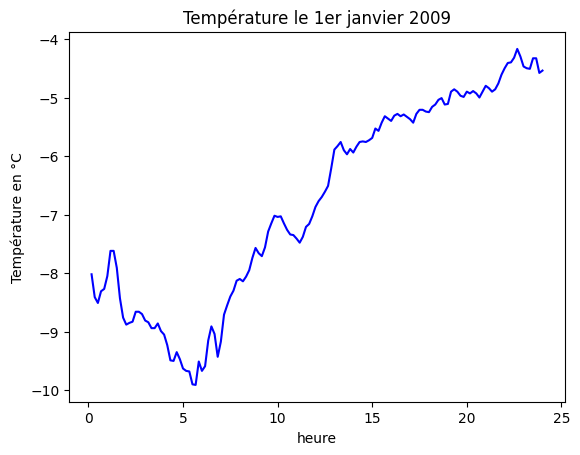

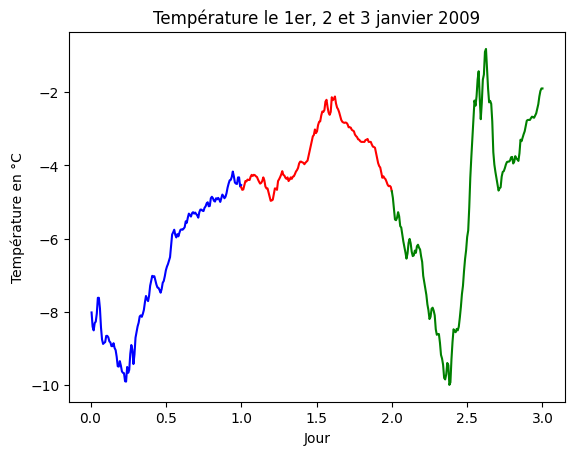

In [3]:
plot ((linspace (1, 144, 144)/144)*24, jena[:144, 1], 'b')
title ("Température le 1er janvier 2009")
xlabel ("heure")
ylabel ("Température en °C")
show ()

plot ((linspace (1, 144, 144)/144), jena[:144, 1], 'b')
plot ((linspace (144, 288, 144)/144), jena[144:288, 1], 'r')
plot ((linspace (288, 432, 145)/144), jena[287:432, 1], 'g')
title ("Température le 1er, 2 et 3 janvier 2009")
xlabel ("Jour")
ylabel ("Température en °C")
show ()

In [4]:
jena.shape

(420551, 14)

## 3. Normalisation des données

In [5]:
mean = jena[:200000].mean (axis = 0)
std = jena[:200000].std (axis = 0)
jena -= mean
jena /= std

## 4. Création du générateur

In [6]:
def generator (data, lookback, delay, mini, maxi, shuffle = False, batch = 128, step = 6) :
    if maxi is None :
        maxi = len (data) - delay
        i = mini + lookback
    while 1:
        if shuffle :
            rows = randint (mini + lookback, maxi, batch)
        else :
            if i + batch >= maxi:
                i = mini + lookback
            rows = arange (i, min (i + batch, maxi))
            i += len (rows)
        samples = zeros ((len (rows), lookback // step, data.shape[-1]))
        targets = zeros ((len (rows),))
        for j, row in enumerate (rows) :
            indices = range (rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay] [1]
        yield samples, targets

In [7]:
lookback = 1440
delay = 144
step = 6
batch = 128

traingen = generator (data = jena, lookback = lookback, delay = delay, mini = 0, maxi = 200000, shuffle = True, batch = batch, step = step)
valgen = generator (jena, lookback, delay, 200001, 300000, shuffle = True)
testgen = generator (jena, lookback, delay, 300001, None, shuffle = True)

valsteps = (300000-200001 - lookback)
teststeps = (len (jena) - 300001 - lookback)


## 5. Création du modèle

In [9]:
model = Sequential ()

model.add (layers.Input (shape = (None, jena.shape[-1])))
model.add (layers.LSTM (32, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True))
model.add (layers.LSTM (64, activation = "relu", dropout = 0.1, recurrent_dropout = 0.5))
model.add (layers.Dense (1))

model.compile (optimizer = RMSprop (), loss = "mae")

model.summary ()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 32)       │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,913 (120.75 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrainnement du modèle

In [ ]:
history = model.fit (traingen, steps_per_epoch = 500, epochs = 20, validation_steps = valsteps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 152ms/step - loss: 33579298188836409966592.0000
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - loss: 53137413556990688362496.0000
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - loss: 102165401260972796396175360.0000
Epoch 4/20
429/500 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 8004019195152482309242880.0000

## 7. Visualisation des performances du modèle

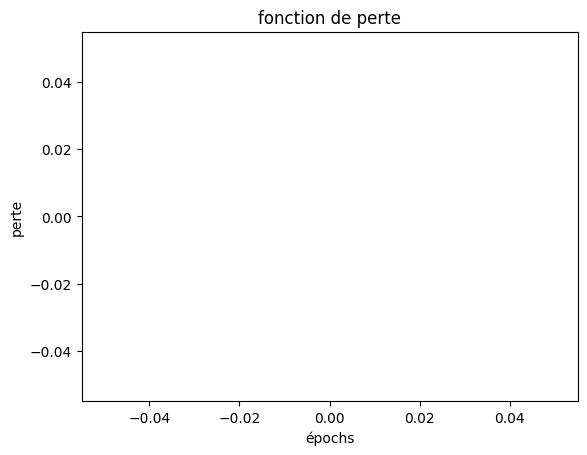

In [28]:
trainloss = history.history ["loss"]

plot (range (20), trainloss, 'b')
title ("fonction de perte")
xlabel ("épochs")
ylabel ("perte")
show ()

## 8. Visualisation des résultats

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


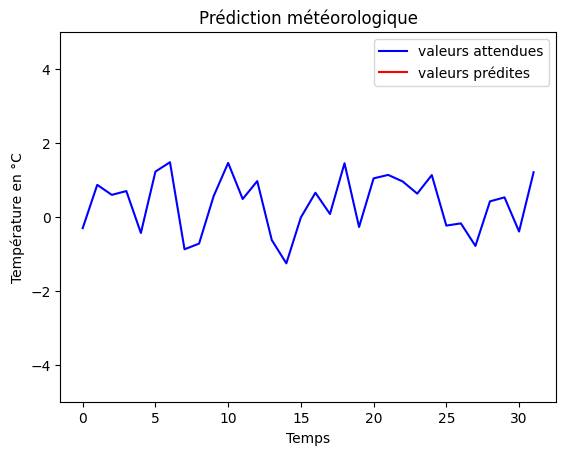

In [29]:
a = next (testgen)
x, y = a[0], a[1]
pred = model.predict (x)

plot (range (32), y[:32], 'blue', label = "valeurs attendues")
plot (range (32), pred[:32], 'red', label = "valeurs prédites")
xlabel ("Temps")
ylabel ("Température en °C")
title ("Prédiction météorologique")
ylim (-5, 5)
legend ()
show ()

## 9. Validation du modèle

In [30]:
loss = model.evaluate (x, y, verbose = 1)
print (" ")
print (f" Le modèle commet en moyenne une imprécision de {round (loss*8.862, 2)}°C")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: nan 
 
 Le modèle commet en moyenne une imprécision de nan°C
